**Helpful Links: Where the Data Lives**

Open Academic Society: [Project Page](https://www.openacademic.ai/oag/)

Microsoft Research: [MS Academic Graph](https://www.microsoft.com/en-us/research/project/microsoft-academic-graph/)

# Imports

In [1]:
import pathlib

# Constants

In [2]:
PROJECT_DIR = pathlib.Path('~/work').expanduser()
DATA_DIR = PROJECT_DIR / 'data'

In [3]:
# https://academicgraphv2.blob.core.windows.net/oag-v1/mag/mag_papers_0.zip
OAG_V1_DATA_DIR = DATA_DIR / 'mag_papers_0'

# Example 9-1

Import + filter data

In [4]:
import pandas as pd

In [5]:
model_df = pd.read_json(OAG_V1_DATA_DIR / 'mag_subset20K.txt', lines=True)
model_df.shape

(20000, 19)

In [6]:
model_df.columns

Index(['title', 'lang', 'year', 'references', 'abstract', 'url', 'id', 'fos',
       'authors', 'publisher', 'doi', 'keywords', 'issue', 'venue', 'volume',
       'doc_type', 'page_start', 'page_end', 'n_citation'],
      dtype='object')

In [7]:
# filter out non-English articles
# keep abstract, authors, fos, keywords, year, title
model_df = (
    model_df
    .query("lang == 'en'")
    .drop_duplicates(subset='title', keep='first')
    .filter(items=['abstract', 'authors', 'fos', 'keywords', 'title', 'year'])
)
model_df.shape

(10399, 6)

In [8]:
model_df.head(2)

,abstract,authors,fos,keywords,title,year
0,A system and method for maskless direct write ...,NaN,"[Electronic engineering, Computer hardware, En...",NaN,System and Method for Maskless Direct Write Li...,2015
1,NaN,[{'name': 'Ahmed M. Alluwaimi'}],"[Biology, Virology, Immunology, Microbiology]","[paratuberculosis, of, subspecies, proceedings...",The dilemma of the Mycobacterium avium subspec...,2016


## Content Based Recommendation using cosine similarity

How to go about building a recommender system? 

Let's start simple with a few fields. We'll calculate the cosine similarity between two items, then rank the results to choose a "most similar" paper for each input.

We can already see that this dataset will need some wrangling. Lists and dictionaries are good for data storage, but not [tidy](http://vita.had.co.nz/papers/tidy-data.html) or well-suited for machine learning without some unpacking.

# Example 9-2

Collaborative filtering stage 1: Build item feature matrix

In [9]:
unique_fos = sorted(list({
    feature
    for paper_row in model_df['fos'].fillna('0')
    for feature in paper_row
}))

unique_year = sorted(model_df['year']
                     .astype('str')
                     .unique())

len(unique_fos + unique_year)

7760

In [11]:
def feature_array(x, unique_array):
    row_dict = {}
    for i in x.index:
        var_dict = {}
        
        for j in range(len(unique_array)):
            if type(x[i]) is list:
                if unique_array[j] in x[i]:
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
            else:    
                if unique_array[j] == str(x[i]):
                    var_dict.update({unique_array[j]: 1})
                else:
                    var_dict.update({unique_array[j]: 0})
        
        row_dict.update({i : var_dict})
    
    feature_df = pd.DataFrame.from_dict(row_dict, orient='index')
    
    return feature_df

In [12]:
%time year_features = feature_array(model_df['year'], unique_year)

CPU times: user 58.9 s, sys: 33.3 ms, total: 58.9 s
Wall time: 58.9 s


In [13]:
%time fos_features = feature_array(model_df['fos'], unique_fos)

CPU times: user 57min 15s, sys: 2.93 s, total: 57min 18s
Wall time: 57min 34s


In [14]:
# now looking at 10399 x  7760 array for our feature space
%time first_features = fos_features.join(year_features).T

CPU times: user 176 ms, sys: 3 ms, total: 179 ms
Wall time: 509 ms


In [15]:
from sys import getsizeof

print('Size of first feature array: ', getsizeof(first_features))

Size of first feature array:  646144594


Let's see how our current features perform at giving us a good recommendation. We'll define a "good" recommendation as a paper that looks similar to the input.

We will start with a simple example of building a recommender with just a few fields, building sparse arrays of available features to calculate for the cosine similary between papers. We will see if reasonably similar papers can be found in a timely manner.

In [16]:
first_features.shape

(7760, 10399)

In [17]:
first_features.head()

,0,1,2,5,7,8,9,10,11,12,...,19985,19986,19987,19988,19993,19994,19995,19997,19998,19999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0-10 V lighting control,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/N expansion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10G-PON,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14-3-3 protein,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Example 9-3

Collaborative filtering stage 2: Search for similar items

In [18]:
from scipy.spatial.distance import cosine

def item_collab_filter(features_df):
    item_similarities = pd.DataFrame(
        data=[(i, j, 1 - cosine(features_df[i], features_df[j]))
              for i in features_df.columns
              for j in features_df.columns],
        columns=['index', 'column', 'value']
    ).pivot(index='index', columns='column', values='value')
    
    return item_similarities

In [19]:
%time first_items = item_collab_filter(first_features.loc[:, :1000])

CPU times: user 1min 21s, sys: 42 ms, total: 1min 21s
Wall time: 1min 21s


We need to get a better idea of how these features will translate to us getting a good recommendation. Do we have enough observations to move forward? Let's plot a heatmap to see if we have any papers that are similar to each other.

# Example 9-4

Heatmap of paper recommendations

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
%matplotlib inline

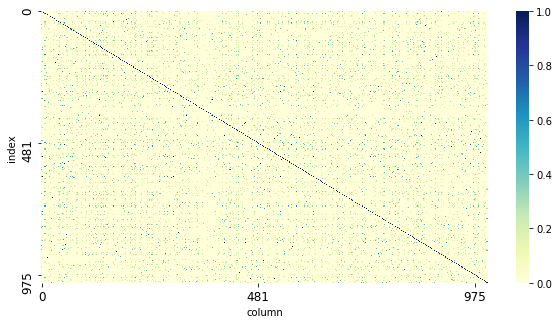

In [22]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(first_items.fillna(0), 
                 vmin=0, vmax=1, 
                 cmap="YlGnBu", 
                 xticklabels=250, yticklabels=250)
ax.tick_params(labelsize=12)

# Example 9-5

Item-based collaborative filtering recommendations

In [23]:
def paper_recommender(paper_index, items_df):
    print('Based on the paper: \nindex = ', paper_index)
    print(model_df.iloc[paper_index])
    top_results = items_df[paper_index].nlargest(4)
    print('\nTop three results: ') 
    order = 1
    for i in top_results.index:
        print(order,'. Paper index = ', i)
        print('Similarity score: ', top_results[i])
        print(model_df.iloc[i], '\n')
        if order < 5: order += 1

In [24]:
paper_recommender(2, first_items)

Based on the paper: 
index =  2
abstract                                                  NaN
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                       NaN
keywords                                                  NaN
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object

Top three results: 
1 . Paper index =  2
Similarity score:  1.0
abstract                                                  NaN
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                       NaN
keywords                                                  NaN
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object 

2 . Paper index =  292
Similarity score:  1.0
abstract                                                  NaN
aut